In [90]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

# Aims

In this notebook, the use of the following variables to predict the current condition of bridges is investigated and reported to Texas Department of Transportation. 

* Predictor variables are:
1. Age (derived from variable Year)
2. average use (variable AverageDaily)
3. percent trucks (variable Trucks_percent)
4. material (variable Material)
5. design (variable Design)

* The target variable is  current condition is derived from following variables:
1. Deck rating
2. Superstr rating
3. Substr rating. 


#### The aim of this analysis to examine:

##### <font color='blue'> How well the proposed variables can predict the bridge condition.</font>
 
##### <font color='blue'> Which of the proposed variables has more influence on the current condition.</font>

# Outline

1. Section 1: Introducing data set
     1. The Source of the Data and the Variables
     1. Loading the Data
     
     
 1. Section 2: Data Preparation
     1. Deriving 'Age' variable from Year variable
     1. Removing Outliers
     1. Reducing number of categories in Material and Design
     1. Creating new variable 'Current condition' from 3 main condition variables
 
 
 1. Section 3: Exploratory Analysis
     1. Overview correlations
     1. Visualizing relationship between Predictor variables and Target variable
     1. Visualizing relationship in Continuous Predictors
     1. Visualizing relationship between Categorical and Continuous variables
     1. Conclusion


 1. Section 4: Regression Modelling
     1. Converting categorical variables to continuous variables
     1. Fitting the Regression Line
     1. Error distribution
     1. Comparing regression coefficients of continuous variables
     1. Comparing regression coefficients of categorical variables
     1. Conclusion

## Section 1. Introducting data set

#### 1.1 The variables
The original data comes from the [National Bridge Inspection](https://www.fhwa.dot.gov/bridge/nbi/ascii.cfm) section of the FHWA's web site. The original FHWA dataset has over 100 variables. Both continuous and categorical variables are included. 

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Structure_id   | Unique identifier of the bridge                  | String |
|District       | Highway district in Texas responsible for bridge | category | 
|Detour_Km      | Length of detour if bridge closed                | continuous |
|Toll           | Whether a toll is paid to use bridge             | category |
|Maintainer     | The authority responsible for maintenance        | category |
|Urban          | Whether the bridge is located in an urban or rural area   | category |
|Status         | The road class: interstate to local                       | category | 
|Year           | The year the bridge was built                             | continuous | 
|Lanes_on       | The number of lanes that run over the bridge              | continuous (or discrete) |
|Lanes_under    | The number of lanes that run under the bridge             | continuous (or discrete) |
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Future_traffic | The estimated daily traffic in approx 20 years time       | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Historic       | Whether the bridge is historic                            | category | 
|Service_under  | The (most important) service that runs under the bridge   | category |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Spans          | The number of spans the bridge has                        | category (or discrete) |
|Length         | The length of the bridge in metres                        | continuous |
|Width          | The width of the bridge in metres                         | continuous |
|Rated_load     | The rated max loading of bridge (in tonnes)               | continuous |
|Scour_rating   | Only for bridges over water: the 'scour' condition        | ordinal |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |



#### 1.2 Loading brigdes data set

Without A type map, Pandas guesses at the types, representing non-numeric fields as string. 
Categorical Variables: using type category gives the default behaviour. The following code creates the necessary categorical types and then uses them to load the data.

In [91]:
#used for an ordinal variable (3 main ratings)
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

#used for a ordinal variable (Scour rating)
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating': scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')

#Dropping missing values
bridges = bridges.dropna()
#Since it is categorical values, those values cannot be filled with mean or median value.
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


####   <font color='red'> Explanation: </font>

From above table, we can see data from the US national bridge inspection.


## Section 2. Data Preparation

####  <font color='blue'> In this section, predictor variables are examined and prepared for constructing regression model. </font>
 
* We want to know how old bridges are. 'Age' variable is derived from the 'Year' variable in the bridges data by calculating the difference between this year (2022) and constructed years of bridges.
* Outlier is data point that differs significantly from other observations. Outliers increase the variability in your data, which decreases result of our regression. Therefore, distributions of predictor variables are illustrated. Very old bridges and outliers in predictor variables are removed.
* There are many number of categories in Design and Material variable. It is recommended to reduce by merging very small categories.
* Current condition of bridges is derived from 3 ratings, which are explaining condition of bridges.

#### 2.1 Deriving Age in years variable from Year variable

In [92]:
# Creating variable 'Age' from Year
bridges = bridges.assign(Age = 2022 - bridges.Year )
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,17
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,17
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,10
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120,72
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,28
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,22
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,26


####   <font color='red'> Explanation: </font>

From above table, we can see 'Age' variable is added to data.

#### 2.2 Excluding very old bridges and outliers in predictor variables

As mentioned, outliers increase the variability in your data, which decreases result of our regression. Consequently, excluding outliers can cause your results to become statistically significant. Thus, outliers in continuous predictor variables are examined using Interquartile range method in the following.

The interquartile range (IQR) is a measure of dispersion, which is the spread of the data. Therefore, outside of interquartile range is considered as outlier.

Text(0.5, 1.0, 'Distribution of Age')

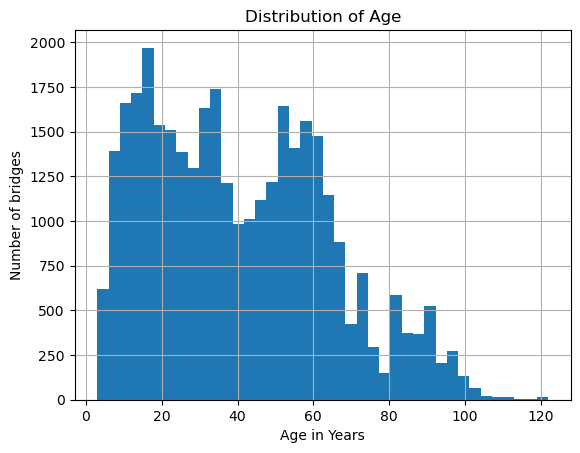

In [93]:
# Examining Age distribution
_ax = bridges['Age'].hist(bins=40)
plt.xlabel('Age in Years')
plt.ylabel('Number of bridges')
plt.title('Distribution of Age')

####   <font color='red'> Explanation and references : </font>
A. https://www.infrastructurereportcard.org/wp-content/uploads/2017/01/Bridges-Final.pdf
According to Infrastructure report card, the average bridge in the U.S. is 43 years old. Most of the country's bridges were designed for a lifespan of 50 years.

B. https://usbridge.com/the-lifespan-of-structurally-deficient-bridges-in-america/
Other sources say bridges are expected to function for 50-70 years.

C. https://savingplaces.org/stories/10-on-tuesday-how-to-preserve-historic-bridges#.Y1QkVi1h28U To be considered historic, a bridge must be at least 50 years of age and either listed or eligible for the National Register according to National Trust USA. As mentioned, lifespan of bridges is between 50 and 70 years. Therefore, Bridges over 70 years will be removed in the following cell.

In [94]:
# Removing very old bridges
bridges = bridges[bridges.Age < 70]

Text(0.5, 0, 'Trucks percent')

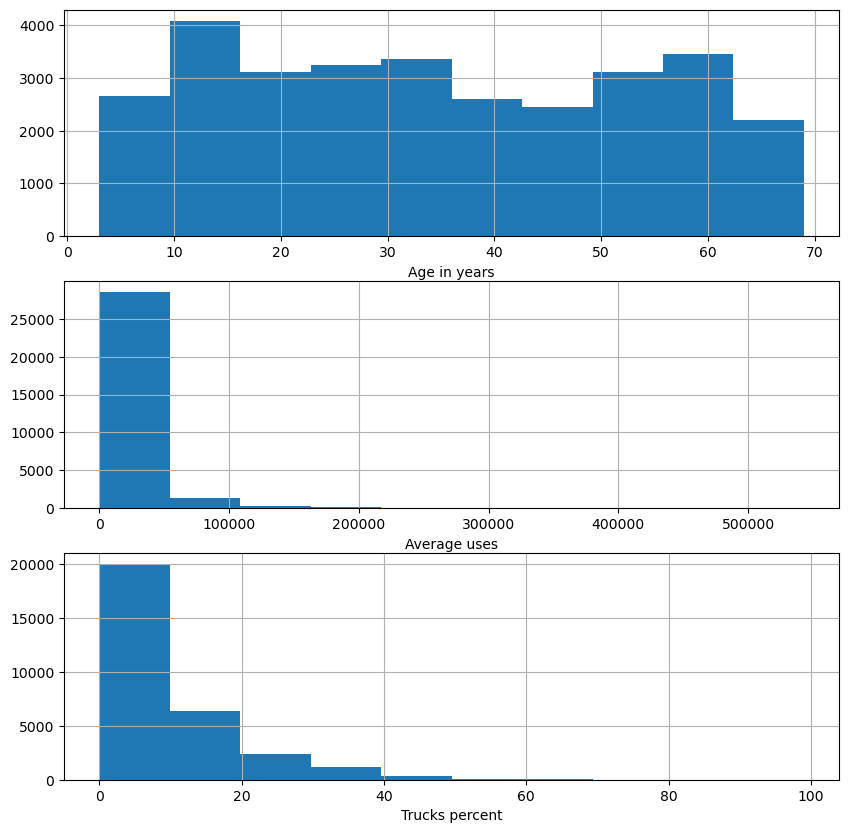

In [95]:
# Distritions of predictor variables
fig, (a1,a2, a3) = plt.subplots(3, 1, figsize=(20,10))
bridges['Age'].hist(figsize = (10,10), bins = 10, ax = a1)
bridges['AverageDaily'].hist(figsize = (10,10), bins = 10, ax = a2)
bridges['Trucks_percent'].hist(figsize = (10,10), bins = 10, ax = a3)

a1.set_xlabel('Age in years')
a2.set_xlabel('Average uses')
a3.set_xlabel('Trucks percent')

####   <font color='red'> Explanation: </font>

Above graphs are illustrating distribution of continuous predictor variables.
Distributions of 'Truck percent' and 'Average Daily' are highly right skewed. Higher skewed data means the data is not evenly distributed. Thus, there could be outliers, which mean unnecessary data in 'AverageDaily' and 'Trucks percent'. We can see that distribution of 'Age' is evenly distributed and older bridges are removed from data. However, there might be outlier. Therefore, we will detect unnecessary data and remove it in the following. 

In [96]:
#Checking outliers
bridges[['AverageDaily','Trucks_percent', 'Age']].describe()

,AverageDaily,Trucks_percent,Age
count,30295.000000,30295.000000,30295.000000
mean,12493.105991,8.305397,34.746592
std,25201.429401,10.291754,18.636863
min,0.000000,0.000000,3.000000
25%,350.000000,0.000000,18.000000
50%,3700.000000,5.000000,33.000000
75%,13000.000000,12.000000,52.000000
max,543000.000000,99.000000,69.000000


####   <font color='red'> Explanation: </font>
As we can see, there are outliers in 'AverageDaily' and 'Trucks_percent' from the summary statistics of the bridges data frame. For example, the max 'AverageDialy' is 543000 while its mean is 12493. The mean is sensitive to outliers, but the fact the mean is so small compared to the max value indicates the max value is an outlier.

As mentioned, There are  in the 'Average Daily' and 'Trucks percent' variables. In the following, we will detect and remove outlier (unnecessary data).

In [97]:
#Creating function to find outliers using Interquartile range method
def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3 - q1
    outliers = data[((data < (q1-1.5 * IQR)) | (data > (q3 + 1.5 *IQR)))]    
    return outliers


outliers = find_outliers(bridges['AverageDaily'])         
outliers_1 = find_outliers(bridges.Age)
outliers_2 = find_outliers(bridges.Trucks_percent)

print('Number of outliers in AverageDialy :' , len(outliers))
print('Number of outliers in Age :' , len(outliers_1))
print('Number of outliers in Trucks_percent :' , len(outliers_2))

Number of outliers in AverageDialy : 2987
Number of outliers in Age : 0
Number of outliers in Trucks_percent : 1479


####   <font color='red'> Explanation: </font>
Detected outliers are 2987 for 'AverageDaily', 0 for 'Age' and 1479 for 'Trucks percent'. It will be removed in the following.


In [98]:
#Removing ouliers of Average Daily
q1 = bridges['AverageDaily'].quantile(0.25)
q3 = bridges['AverageDaily'].quantile(0.75)
IQR = q3 - q1
bridges = bridges[~((bridges['AverageDaily'] < (q1
                                               - 1.5 * IQR)) | (bridges['AverageDaily'] > (q3 + 1.5 *IQR)))]
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,17
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,17
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,10
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,18
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,...,49.1,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,28
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,22
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,26


####   <font color='red'> Explanation: </font>
Above table shows the data after removing unnecessary data in Average Daily variable.


In [99]:
#Removing outliers of Trucks_percent
q1 = bridges['Trucks_percent'].quantile(0.25)
q3 = bridges['Trucks_percent'].quantile(0.75)
IQR = q3 - q1
bridges = bridges[~((bridges['Trucks_percent'] < (q1
                                               - 1.5 * IQR)) | (bridges['Trucks_percent'] > (q3 + 1.5 *IQR)))]
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,17
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,17
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,10
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,18
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,...,49.1,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPAMCSTA000002,District15,0,Free,Military,Rural,Local,1975,2,0,200,...,17.1,6.9,Satisfactory,Satisfactory,Fair,26.6,12.0,Dry,300,47
DAPFORHOO000004,District9,5,Free,Military,Urban,Local,1991,2,0,800,...,32.2,9.1,Good,Good,Good,15.6,25.0,Dry,1000,31
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,26


####   <font color='red'> Explanation: </font>
Above table shows the data after removing unnecessary data in Trucks_percent variable.

#### 2.3 Reducing the number of categories of materials and design by merging some of the very small categories

Since there are many small categories in Material and Design variables, it is better to merge small categories.

In [100]:
# Examining categories in Material
print(bridges.Material.value_counts())

Concrete    20878
Steel        4818
Timber        417
Other          38
Masonry         1
Name: Material, dtype: int64


####   <font color='red'> Explanation: </font>
There are 5 categories but 'Concrete', 'Steel' and Timber  are counted most. Small categories such as 'Other'and Masonry will be labeled as 'Others'.

#### Merging small categories in Material variable

In [101]:
#### Merging small categories in Material variable
bridges.Material = bridges['Material'].replace([ 'Other', 'Masonry'], 'Others')
bridges.Material.value_counts()

Concrete    20878
Steel        4818
Timber        417
Others         39
Name: Material, dtype: int64

####   <font color='red'> Explanation: </font>
From above, Small categories labeled as Others.

In [102]:
# Examining categories in Design
print(bridges.Design.value_counts())

Beam          22315
Slab           2496
Other          1170
Arch             89
Frame            49
Truss            20
Movable          11
Suspension        2
Name: Design, dtype: int64


####   <font color='red'> Explanation: </font>
There are 8 categories in the Design column. However, 'Beam', 'Slab' and 'Other' categories are major categories over 1000 counts. Therefore, we will reduce the number of categories into 3, and 'Arch', 'Frame', 'Truss', 'Movable', and Suspension are added to 'Others'.

#### Merging small categories in Design variable

In [103]:
bridges.Design = bridges.Design.replace(['Arch', 'Frame', 'Other', 'Truss', 'Movable', 'Suspension'], 'Others')
bridges.Design.value_counts()

Beam      22315
Slab       2496
Others     1341
Name: Design, dtype: int64

####   <font color='red'> Explanation: </font>
From above, small categories are labeled as 'Others'.

#### 2.4 Creating new variable 'Current condition'

The current condition should be derived from the combination of the three main condition variables (Superstr rating, Deck rating, and Substr rating). 3 rating variables have ordinal values. These ordinal variables are converted in this part of the section by each values as numbers.

Values are replaced as follows.

(Excellent as 9, 
Very Good as  8, 
Good as 7, 
Satisfactory as  6,
Fair as  5,
Poor as 4,
Serious as 3, 
Critical as 2, 
Failing as  1 and Failed as 0).

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

| Variable      |      Values            |
|:--------------|:-----------------------|
|Deck_rating    | *Rating*: Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed |
|Superstr_rating| *Rating* Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed|
|Substr_rating  | *Rating* Excellent, Very Good, Good, Satisfactory, Fair, Poor, Serious, Critical, Failing, Failed|

In [104]:
#Creating dictionary for current condition
current_cond= {'Excellent' : 9, 'Very Good': 8, 'Good' :7, 'Satisfactory' : 6,
               'Fair' : 5, 'Poor' : 4, 'Serious' : 3, 'Critical' : 2, 'Failing': 1, 'Failed': 0}
#Creating function that converts categorical values to continuous variable in Superstr rating catergory
def Superstr_rating(row): 
    if row.Superstr_rating in current_cond:
        return current_cond[row.Superstr_rating]
    return row.Superstr_rating

#Creating function that converts categorical values to continuous variable in Deck rating catergory
def Deck_rating(row): #Function that converts to integer in Deck_rating
    if row.Deck_rating in current_cond:
        return current_cond[row.Deck_rating]
    return row.Deck_rating

#Creating function that converts categorical values to continuous variable in Substr rating catergory
def Substr_rating(row):#Function that converts to integer in Substr_rating
    if row.Substr_rating in current_cond:
        return current_cond[row.Substr_rating]
    return row.Substr_rating

####   <font color='red'> Explanation: </font>
From above, a Function is created to convert categories to numbers. In the following cell, function is applied on bridges data.

In [105]:
#Applying function on each variables
Superstr_rating = bridges.apply(Superstr_rating, axis = 1)
Deck_rating = bridges.apply(Deck_rating, axis = 1)
Substr_rating = bridges.apply(Substr_rating, axis = 1)

#Creating new variable called Current condition
bridges = bridges.assign(Current_condition = Superstr_rating + Deck_rating + Substr_rating)
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age,Current_condition
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,17,23
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,17,22
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,10,24
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,18,23
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,...,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,17,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPAMCSTA000002,District15,0,Free,Military,Rural,Local,1975,2,0,200,...,6.9,Satisfactory,Satisfactory,Fair,26.6,12.0,Dry,300,47,17
DAPFORHOO000004,District9,5,Free,Military,Urban,Local,1991,2,0,800,...,9.1,Good,Good,Good,15.6,25.0,Dry,1000,31,21
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,26,21


####   <font color='red'> Explanation: </font>
From above table, we can see that 'Current condition' score is added to the dataframe.

## Section 3. Exploratory Analysis

####  <font color='blue'> In this section, Relationship between all variables are visualized and explained. </font>

* Overview correlations
* Relationship between predictor variables and target variable
* Relationship between predictor variables
* Relationship between categorical variables
* Conclusion

In [106]:
#Creating dataframe contains 'Predictors' and 'Target'
bridges = bridges[['AverageDaily','Trucks_percent', 'Age', 'Material', 'Design', 'Current_condition' ]]
bridges

,AverageDaily,Trucks_percent,Age,Material,Design,Current_condition
Structure_id,,,,,,
000021521-00101,1,0.0,17,Concrete,Slab,23
000021521-00181,1,0.0,17,Concrete,Slab,22
000021521-TMP20,100,0.0,10,Concrete,Beam,24
000021580-00092,150,4.0,18,Concrete,Beam,23
000021580-00093,150,4.0,17,Concrete,Beam,24
...,...,...,...,...,...,...
DAPAMCSTA000002,200,12.0,47,Concrete,Beam,17
DAPFORHOO000004,800,25.0,31,Concrete,Beam,21
DAPFORHOO000015,1200,25.0,26,Concrete,Beam,21


####   <font color='red'> Explanation: </font>
Above table has 6 variables to predict current condition of bridges. Table includes 5 predictors ('AverageDaily', 'Trucks_percent', 'Age', 'Material', 'Design') and target value (Current condition) score.

#### 3.1 Overview correlations

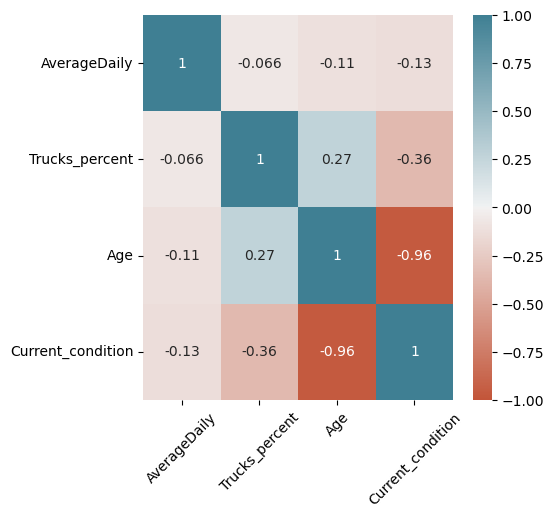

In [107]:
# Correlation shown as heat map
heat_map = bridges.corr()
fig,ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(heat_map.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 10})
_y = plt.yticks(rotation=0, fontsize=10)
_x = plt.xticks(rotation=45, fontsize=10)

####   <font color='red'> Explanation: </font>

Above heat map illustrates relationship between continuous predictor variables and current condition. Correlation coefficients whose magnitude are +1 and -1, indicate strong relationship with each other. In contrast, 0 means no relationship.

1. According to the heatmap created above, the highly correlated variable to the target (Current condition) is 'Age' (-ve correlation) which is '0.96', while 'Average Daily' and 'Trucks percent' are only correlated with '-0.13' and '-0.36' respectively.

2. when bridge is getting old, bridge condition will decline.

3. Relationship between continuous variables are very small.

In the following, the relationship between each predictor variable and the target value is visualized.

#### 3.2 Relationship between predictor variables and target variable

Since there is lot of data for each variables in scatter plot, we will use hexbin plot or select 1% bridges data to see relationship between each variables.

<AxesSubplot:xlabel='AverageDaily', ylabel='Current_condition'>

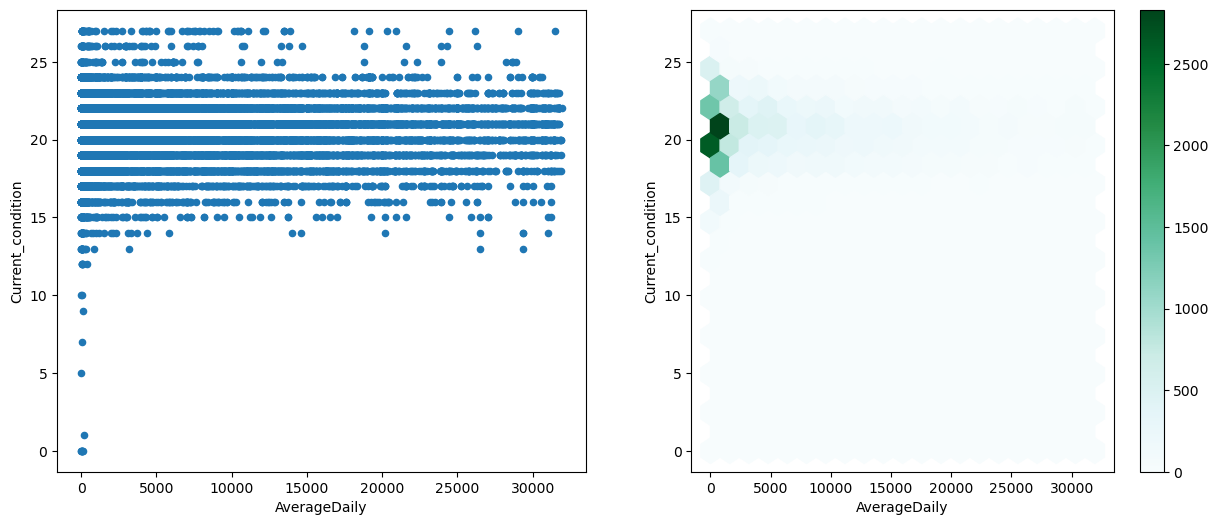

In [108]:
#Visualizing relationship between Average uses and Current condition
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.plot(x = 'AverageDaily', y = 'Current_condition', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'AverageDaily', y ='Current_condition',  gridsize=20, sharex=False , ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'AverageDaily' and 'Current Condition' visually.
In the scatter plot graph between AverageDaily and Current condition, there is almost no relationship visually. However, there is a very slight relationship between 0 to 5000 number of average uses where the current is always good between 15 to 25. Moreover, in hexbin plot, we can see that the darker green color (most counted) has a small number of average uses and good current condition.

<AxesSubplot:xlabel='Age', ylabel='Current_condition'>

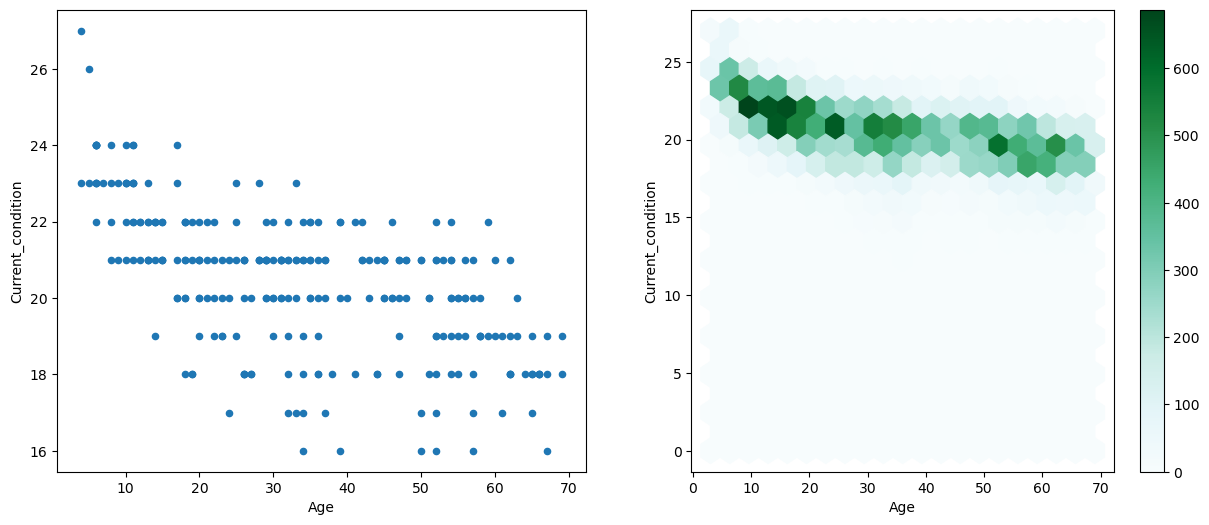

In [109]:
#Visualizing relationship between Age and Current condition
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.sample(frac = 0.01).plot(x = 'Age', y = 'Current_condition', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'Age', y ='Current_condition',  gridsize=20, sharex=False , ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'Age' and 'Current Condition' visually.
The scatter plot between 'Age' variable and Current condition score illustrates that there is a negative high relationship. In other words, when bridges get old, the current condition score decreases. We can see the same relationship in the second plot as well. Overall, older bridges have bad current condition scores.

<AxesSubplot:xlabel='Trucks_percent', ylabel='Current_condition'>

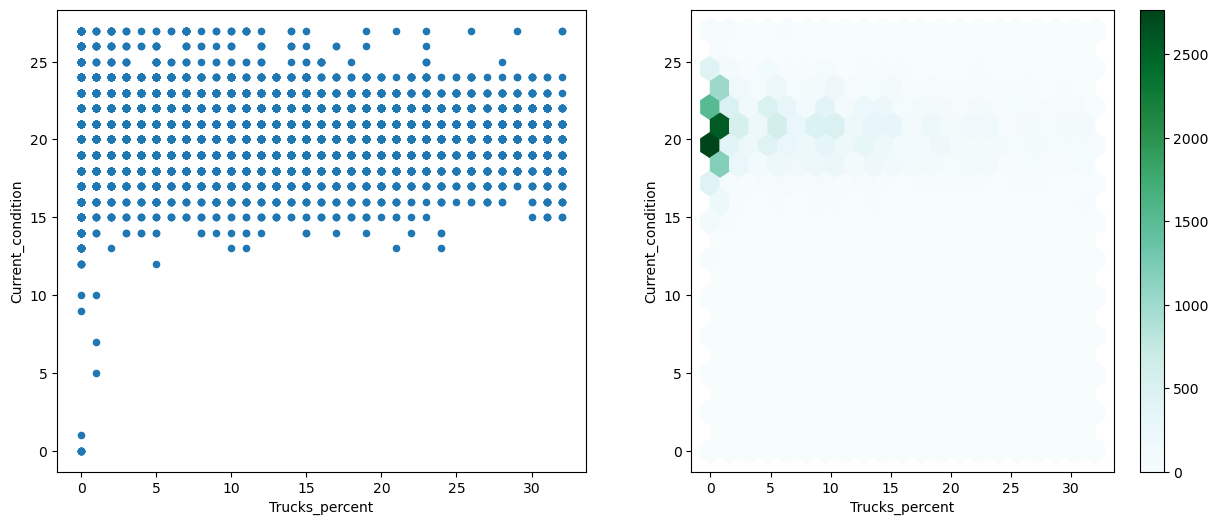

In [110]:
#Visualizing relationship between Trucks percent and Current condition
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.plot(x = 'Trucks_percent', y = 'Current_condition', kind = 'scatter', ax = a1)
#bridges.plot(x = 'Trucks_percent', y = 'Current_condition', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'Trucks_percent', y ='Current_condition',  gridsize=20, sharex=False, ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'Trucks_percent' and 'Current Condition' visually.
In the scatter plot between 'Trucks percent' and the Current condition score, we see that there is not much relationship same as Age and Current condition. However, when trucks percent is low, current condition score is around 15 to 25 scores. When truck percent increases, current is longer around  15 to 20 instead 15 to 25 scores. Meaning there is a low relationship (-ve correlation) between current condition score and trucks percent. Overall, Bridges which having small number Trucks are in good condition.

<AxesSubplot:xlabel='Design', ylabel='Current_condition'>

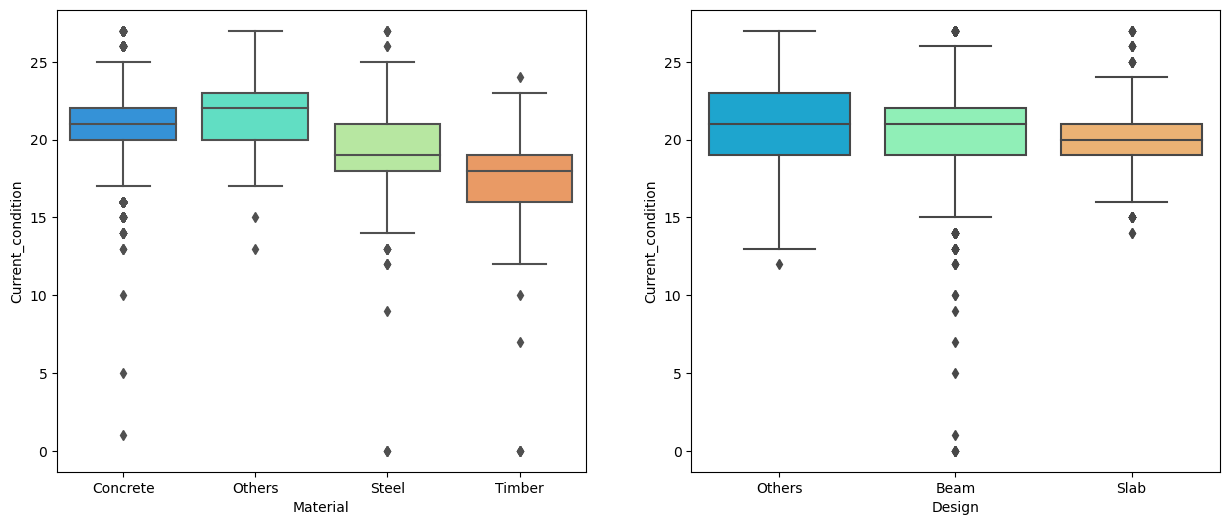

In [111]:
# Visualizing relation between Categorical variables and Current condition score
fig, (a1, a2) = plt.subplots(1, 2, figsize=(15, 6))
# Boxplot between Current condition and Material
sns.boxplot(x = 'Material', y = 'Current_condition',data = bridges, palette='rainbow', ax = a1)
# Boxplot between Current condition and Material
sns.boxplot(x = 'Design', y = 'Current_condition',data = bridges, palette='rainbow', ax = a2)

####   <font color='red'> Explanation: </font>
These boxplot graphs illustrate relationship between categorical variables and current condition score.

The first boxplot between Material and Current condition score shows that bridges made of concrete and others material are in good condition above 22 scores and 23 scores respectively according to average values (average value from a set of data and is shown by the line that divides the box into two parts) . In contrast, Bridges made of timber and Steel materials have a lower current condition score than bridges made of by concrete and other materials. Although timber and steel bridges have lower scores than concrete bridges and other bridges, current conditions are spread around 14 to 20  for timber bridges and about 16 to 23 for steel bridges. Overall, we can see that Timber  and Steel bridges are generally in worse condition than concrete bridges, and others bridges. This explains the material does make a difference.

The second boxplot illustrates the relationship between the design and the current condition score. 'Others' designed bridges have long-range around 14 scores (min) to 26 scores (max) due to various mixed designs. Beam bridges have current condition scores between 15 and 26, while Slab bridges have 16 scores to 24 scores. Overall, there is very small relationship between designs and current conditions. Because average values are almost same between Beam and Others.

#### 3.3 Relationship between Predictor variables

<AxesSubplot:xlabel='Trucks_percent', ylabel='AverageDaily'>

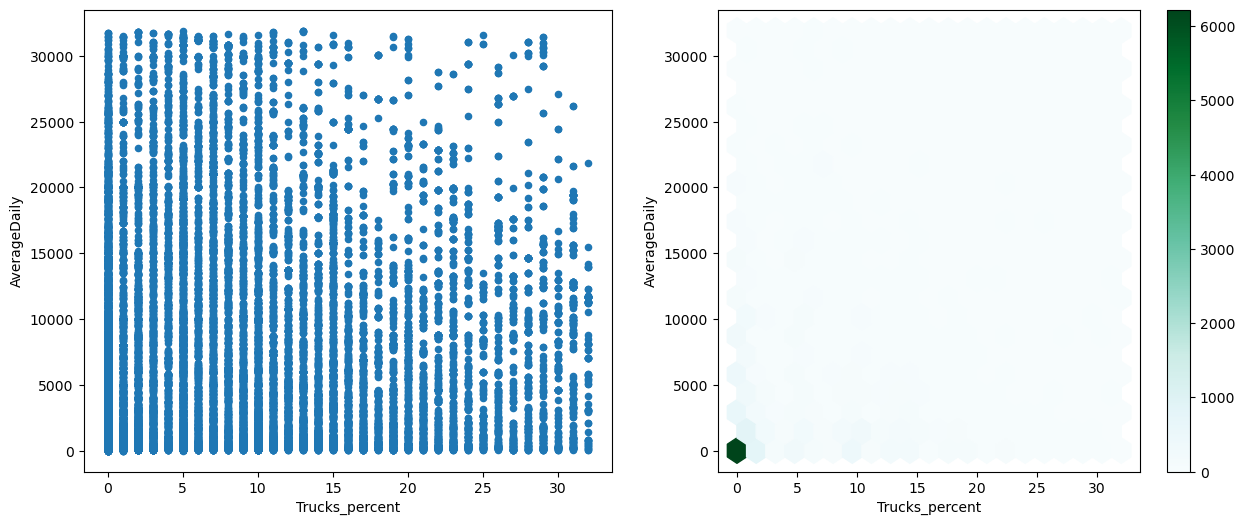

In [112]:
#Visualizing relationship between Trucks percent and Average Daily
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.plot(x = 'Trucks_percent', y = 'AverageDaily', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'Trucks_percent', y ='AverageDaily',  gridsize=20, sharex=False , ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'Trucks_percent' and 'AverageDaily' visually.
The scattter plot and hexbin plot show there is no relationship between Average uses and Trucks percent visually. Because points are scattered everywhere and hard to see relationship.

<AxesSubplot:xlabel='Age', ylabel='AverageDaily'>

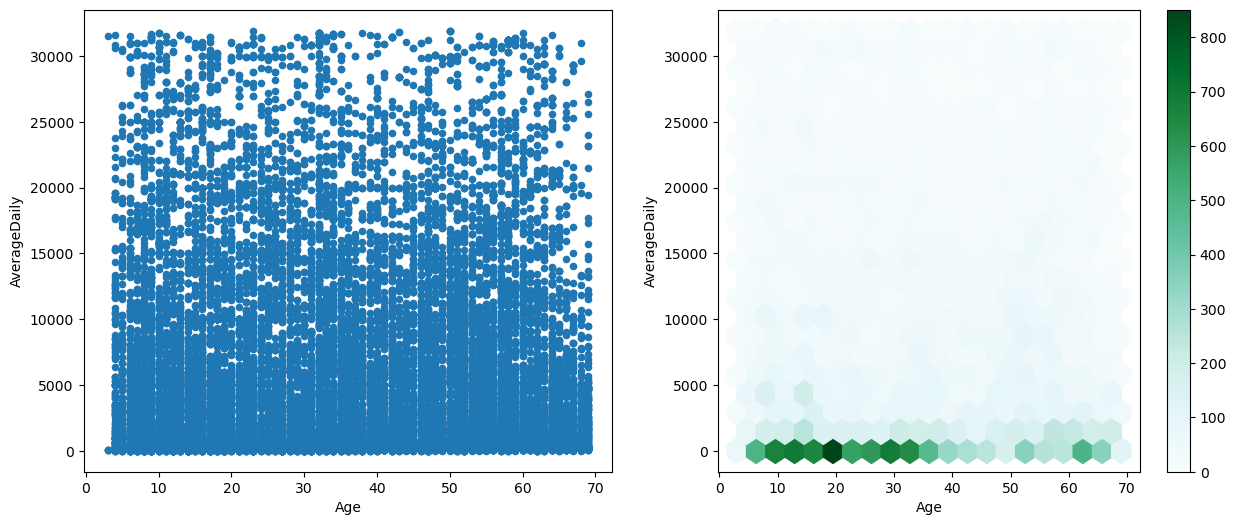

In [113]:
#Visualizing relationship between Age and Average Daily
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.plot(x = 'Age', y = 'AverageDaily', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'Age', y ='AverageDaily',  gridsize=20, sharex=False , ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'Age' and 'AverageDaily' visually.
Both scatter plot and hexbin plot show there is no relationship between Age and Average uses visually. Because points are scattered everywhere and hard to see relationship.

<AxesSubplot:xlabel='Age', ylabel='Trucks_percent'>

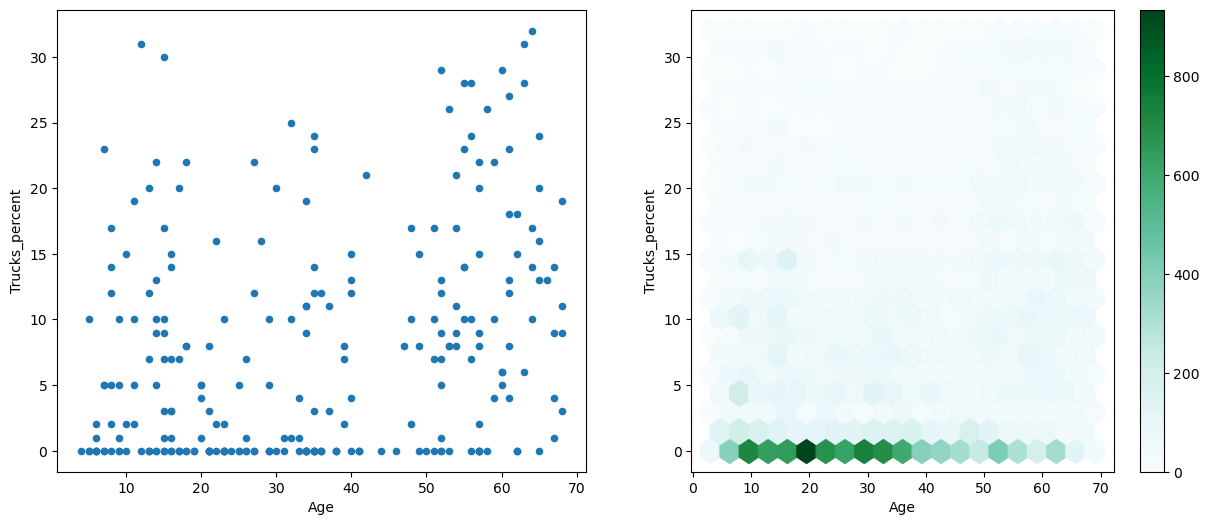

In [114]:
#Visualizing relationship between Age and Average Daily
fig, (a1,a2) = plt.subplots(1, 2, figsize=(15,6))
bridges.sample(frac = 0.01).plot(x = 'Age', y = 'Trucks_percent', kind = 'scatter', ax = a1)
bridges.plot(kind='hexbin', x = 'Age', y ='Trucks_percent',  gridsize=20, sharex=False , ax = a2)

####   <font color='red'> Explanation: </font>
The above graphs show a relationship between 'Trucks_percent' and 'Age' visually.
Both scatter plot and hexbin plot show there is no relationship between Age and Trucks percent visually.

[None]

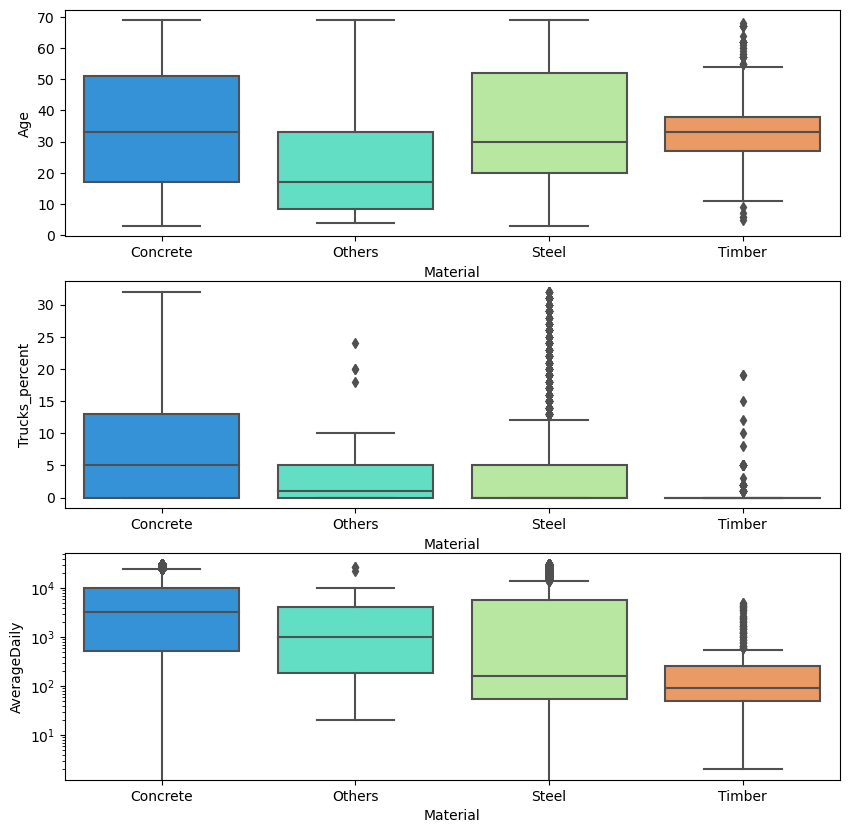

In [115]:
#Visualizing relation between Material and Continuous variables
fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(10, 10))

sns.boxplot(x = 'Material', y = 'Age',data = bridges, palette='rainbow', ax = a1)
sns.boxplot(x = 'Material', y = 'Trucks_percent',data = bridges, palette='rainbow', ax = a2)
sns.boxplot(x = 'Material', y = 'AverageDaily',data = bridges, palette='rainbow',  ax = a3)
a3.set(yscale = 'log')

####   <font color='red'> Explanation: </font>

These boxplot graphs illustrate relationship between Material and Continuous variables.

In the first boxplot, Timber bridges and 'Others material' bridges are younger than Concrete bridges and Steel bridges. Because Age ranges are around 18 years to 50 years and Age averages are around 30 years for Concrete bridges, around 20 years to 50 years and 28 years for Steel bridges, about 28 years to 35 years and 30 years for Timber bridges, and 10 years to 30 years and 18 years for 'Other material' bridges. This explains 'Others' bridges are usually younger than Concrete bridges, Steel bridges, and Timber bridges.


In the second boxplot, Concrete bridges have more trucks percent than Timber bridges, Steel bridges, and 'Other material' bridges. Timber bridges have no trucks percent. This explains no trucks go on Timber bridges without counting outliers. Concrete bridges have highest trucks percentage compare to other types of bridges.

The third boxplot shows a relation between Bridge average uses and bridge material. Concrete bridges have high average uses about over 1000 while timber bridges and steel bridges have the lowest average uses about 100. Others bridges have bit lower average uses than Concrete bridges.

[None]

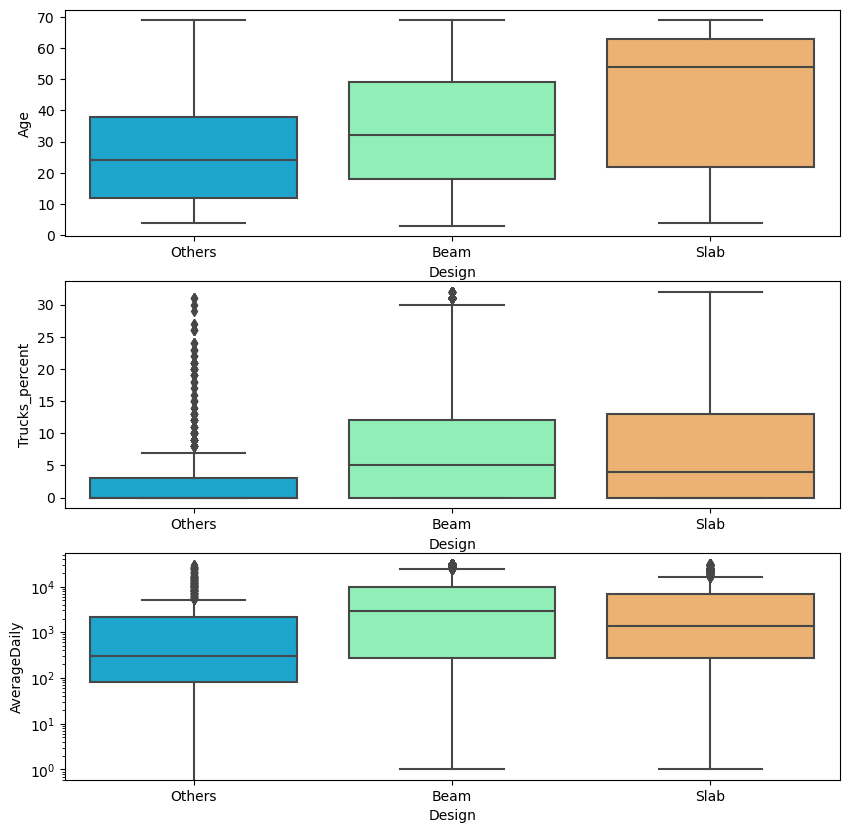

In [116]:
#Visualizing relation between Design and Continuous variables
fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(10, 10))

sns.boxplot(x = 'Design', y = 'Age',data = bridges, palette='rainbow', ax = a1)
sns.boxplot(x = 'Design', y = 'Trucks_percent',data = bridges, palette='rainbow', ax = a2)
sns.boxplot(x = 'Design', y = 'AverageDaily',data = bridges, palette='rainbow',  ax = a3)
a3.set(yscale = 'log')

####   <font color='red'> Explanation: </font>

These boxplot graphs illustrate relationship between Design and Continuous variables.

In the first boxplot, 'Other' designed bridges and Beam bridges are younger than Slab bridges. Because bridges age range are 20 years to 60 years for Slab bridges, 20 years to 45 years for Beam bridges, and 10 years to 36 years for 'Other design' bridges. Overall, Slab bridges are oldest followed by Beam and Other designed bridges.

In the second boxplot, 'Other design' bridges have a lower truck percent than slab bridges and beam bridges. Because average trucks percent is almost 0 for 'Others' designed bridges. Overall, Slab and Beam bridges have higher trucks percentage than 'Other design' bridges.

The third boxplot shows the relation between Bridge average uses and bridge design. Beam bridges have highest average daily uses (about 1000) than Slab bridges and 'Other design' bridges. Overall, 'Other design' bridges have lower average daily uses than beam and slab bridges.

#### 3.4 Relationship between Material and Design variables

In the following, Relationship between Material and Design will be visualized based on conditional probability distribution. For instance: given that bridges are concrete, what probability is that has beam design.

Text(0.5, 1.0, 'Probability of Design, given Material')

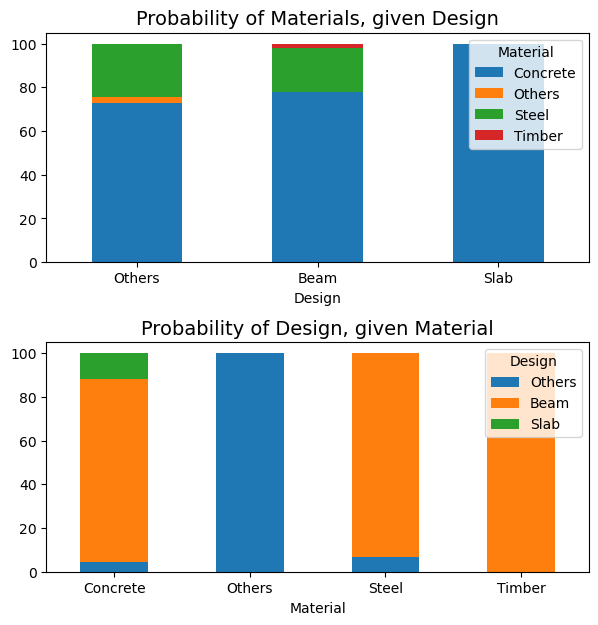

In [117]:
#Conditional probability Design and Material
mat_given_des = pd.crosstab(bridges.Design, [bridges.Material], normalize='index')
des_given_mat = pd.crosstab(bridges.Material, [bridges.Design], normalize='index')

#Display as percentages
c = mat_given_des.round(4) * 100
d = des_given_mat.round(4) * 100

fig,(a1, a2) = plt.subplots(2,1,figsize=(7,7), sharey=False, sharex=False)
fig.subplots_adjust(hspace=0.35)

#Visualizing Conditional Probability of Materials, given Design
c.plot(kind='bar', subplots=False, ax=a1, rot=0, stacked=True)
a1.set_title('Probability of Materials, given Design', fontsize=14)

#Visualizing Conditional Probability of Design, given Material
d.plot(kind='bar', subplots=False, ax=a2, rot=0, stacked = True)
a2.set_title('Probability of Design, given Material', fontsize=14)

####   <font color='red'> Explanation: </font>
Above graphs illustrate relationship between Material and Design variables.
The first bar chart shows the Probability of Materials given Design. Around 80% of Beam bridges are mostly made of approximately concrete. '70% of Others' designed bridges are made of concrete, and 23 % of 'Others' designed bridges are made of steel. All of Slab-designed bridges are made of by concrete.

The second bar chart shows the Probability of Design given Material. Around 80% of Concrete bridges have mostly beam design and around 10% of concrete bridges have slab design. 'Others' bridges have various types of designs. Steel bridges have mostly beam design. Lastly, Timber bridges have a 100% beam design. 

Overall, Most of the bridges are made of concrete and have beam design.

#### 3.5 Conclusion

* How well the proposed variables can predict the bridge condition?

Since there are small relationships between design variables, trucks percent, average uses and current condition score, the prediction of current condition bridge seems cannot be highly explained by these 3 predictor variables. Thus, prediction model would be mostly explained by 'Age' variable.

* Which of the proposed variables has more influence on the current condition?

As mentioned, Age and current condition have a high negative relationship, which means older bridges have worse current condition.Also, Material and current condition have relationship. For example: bridges are made of concrete and 'others' material are good condition. Thus, Age and material would affect most for predicting the current condition of bridges.

## Section 4. Regression Modelling

####  <font color='blue'> In this section, Linear regression is constructed using five predictor variables on the target variable. </font>

* Converting categorical values to numeric values
* Fitting the Regression Line
* Comparing the regression Coefficients of continuous variables
* Comparing the regression Coefficients of categorical variables
* Error distribution
* Conclusion

#### 4.1 Converting categorical values to numeric values

There are two categorical variables, cannot be added to regression model. To use categorical predictors, we must transform them to integer values using reference encoding. In the following, Design and Material are converted to numeric variables.


In [118]:
#Encoding
Design_d = pd.get_dummies(bridges.Design, drop_first = True)
Material_d = pd.get_dummies(bridges.Material, drop_first = True)
print(Design_d)
print(Material_d)

                 Beam  Slab
Structure_id               
000021521-00101     0     1
000021521-00181     0     1
000021521-TMP20     1     0
000021580-00092     1     0
000021580-00093     1     0
...               ...   ...
DAPAMCSTA000002     1     0
DAPFORHOO000004     1     0
DAPFORHOO000015     1     0
DAPFORHOO00005A     1     0
DAPTRABLI000011     1     0

[26152 rows x 2 columns]
                 Others  Steel  Timber
Structure_id                          
000021521-00101       0      0       0
000021521-00181       0      0       0
000021521-TMP20       0      0       0
000021580-00092       0      0       0
000021580-00093       0      0       0
...                 ...    ...     ...
DAPAMCSTA000002       0      0       0
DAPFORHOO000004       0      0       0
DAPFORHOO000015       0      0       0
DAPFORHOO00005A       0      0       0
DAPTRABLI000011       0      1       0

[26152 rows x 3 columns]


####   <font color='red'> Explanation: </font>
From above, we can see that Design and Material are converted to numeric variables.


#### 4.2 Fitting the Regression Line

In the following, all 5 predictors and target value are constructed to predict current condition of bridges.

In [119]:
#Stacking converted categorical variables
design_material = np.column_stack((Design_d.Beam,Design_d.Slab, Material_d.Steel, Material_d.Others , Material_d.Timber ))

#Stacking Predictor variables and Target variable
X = np.column_stack((bridges.AverageDaily, bridges.Age, bridges.Trucks_percent, design_material))
y = bridges.Current_condition

#Fitting regression line
reg = LinearRegression().fit(X, y)

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))

The R2 coefficient of determination is 0.471


####   <font color='red'> Explanation: </font>
The R2 coefficient is the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, R2 shows how well the data fit the regression model.
0.471 indicates that the independent variables explain 47.1% of the variation in the target variable (52.9% of the variability in the outcome data cannot be explained by the model). Thus, model can't predict well.

#### 4.3 Error distribution

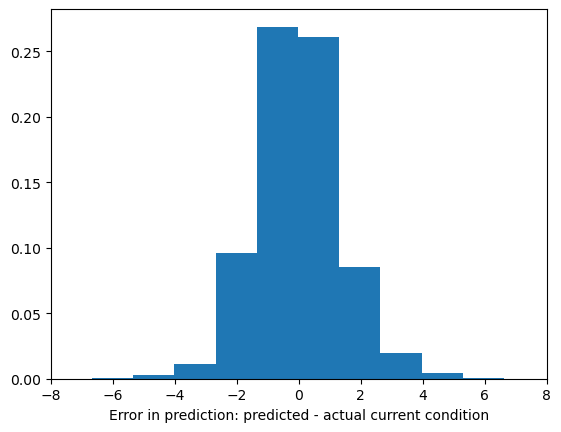

In [120]:
# Return predicted values
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y # Calculating error between predicted values and target values
a1.hist(residuals, bins = 20, density=True) # Plotting Error distribution
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')
plt.xlim(-8, 8)

plt.show()

####   <font color='red'> Explanation: </font>

The histogram graph illustrates error (predicted - actual) distribution. The x-axis shows the error in prediction and the y-axis shows frequency. This graph tells us how far predicted values are from actual current condition. For example: The error of 0 has a frequency of  25%, which explains that 25% of predicted data has no errors with actual current condition data. Overall, we can see that most of errors is between around -1.5 and 1.5. 

Text(0, 0.5, 'Actual')

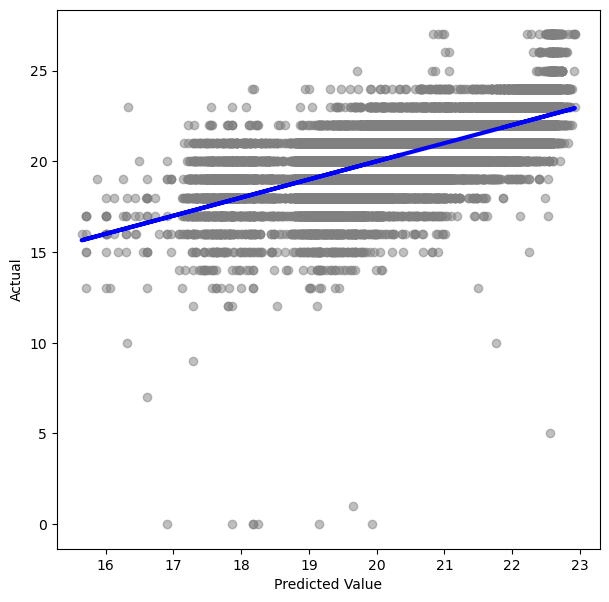

In [121]:
# Plot outputs
fig, a = plt.subplots(1,1, figsize = (7,7))
a.scatter(y_hat, y, color = 'grey', alpha = 0.5)
a.plot(y_hat,y_hat, color = 'blue', linewidth = 3)

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual')

####   <font color='red'> Explanation: </font>

From above, we can see predicted values against actual values visually. If points are fitted better, points would be near blue line


#### 4.4 Comparing the regression coefficients of continuous variables

Regression coefficients describe the relationship between a predictor variable and target variable. In the following, which variables are more influence on current condition of bridge will be examined based on regression coefficients.

In [122]:
#Assigning beta values
beta_AD, beta_Age, beta_Trucks, beta_Beam, beta_Slab, beta_Steel, beta_Others, beta_Timber = reg.coef_

In [123]:
print('Regression coefficient for AverageDaily is %4.3f' % beta_AD, 'change of current condition score of bridge  per count')
print('Regression coefficient for Age is %4.3f' % beta_Age, 'change of current condition score of bridge  per year')
print('Regression coefficient for Trucks percent is %4.3f' % beta_Trucks, 'change of current condition score of bridge  per percent')

Regression coefficient for AverageDaily is -0.000 change of current condition score of bridge  per count
Regression coefficient for Age is -0.060 change of current condition score of bridge  per year
Regression coefficient for Trucks percent is 0.009 change of current condition score of bridge  per percent


####   <font color='red'> Explanation: </font>
These coefficient values represent the mean change in the response given a one-unit change in the predictor.
For example, The current condition score decreases by -0.06 for every year. We can see there is no change in Average Daily variable, and there is small changes in Trucks percent. 

The coefficients of a linear regression have units. The values will change if we scale the predictors. Thus, we will compare based on the distributions of each variable in the following.

In [124]:
#Calculating ranges
Ave_uses_R = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
Trucks_percent_R = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
Age_R = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
Current_cond_range = bridges.Current_condition.quantile(0.9) - bridges.Current_condition.quantile(0.1)

print('Range of average daily uses is:', Ave_uses_R )
print('Range of Trucks percent is:', Trucks_percent_R, '%')
print('Range of Age  is:', Age_R, 'years')
print('Range of target values is :' , Current_cond_range)



Range of average daily uses is: 17635.0
Range of Trucks percent is: 20.0 %
Range of Age  is: 51.0 years
Range of target values is : 5.0


####   <font color='red'> Explanation: </font>
From above, we can see range of each variables.

In [125]:
print ('The change in Current condition score  given by the Average uses coefficient (over its range) is %4.1f percent'
       % (100 * (beta_AD * Ave_uses_R) / Current_cond_range))

print ('The change in Current condition score  given by the Trucks percent coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Trucks * Trucks_percent_R) / Current_cond_range))

print ('The change in Current condition score  given by the Age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * Age_R) / Current_cond_range))

The change in Current condition score  given by the Average uses coefficient (over its range) is -0.7 percent
The change in Current condition score  given by the Trucks percent coefficient (over its range) is  3.5 percent
The change in Current condition score  given by the Age coefficient (over its range) is -61.3 percent


####   <font color='red'> Explanation: </font>
From this calculation results, we can see Age has the most influence on current condition of bridge while Average Daily is only -0.7 percent change and Trucks percent is +3.5 percent change. Thus, Age has more influence on current condition score as expected in Exploratory analysis.

#### 4.5 Comparing the regression coefficients of categorical variables

In the following, which variables are more influence on current condition of bridge will be examined based regression coefficients.

In [126]:
print('Comparing to Others designed bridges, regression coefficient for Beam design is %4.3f' % beta_Beam,'change of current condition score of bridge')
print('Comparing to Others designed bridges, regression coefficient for Slab design is %4.3f' % beta_Slab,'change of current condition score of bridge')
print('Comparing to Concrete bridges, regression coefficient for Steel material is %4.3f' % beta_Steel,'change of current condition score of bridge')
print('Comparing to Concrete bridges, regression coefficient for Others material is %4.3f' % beta_Others,'change of current condition score of bridge')
print('Comparing to Concrete bridges, regression coefficient for Timber material is %4.3f' % beta_Timber,'change of current condition score of bridge')

Comparing to Others designed bridges, regression coefficient for Beam design is 0.033 change of current condition score of bridge
Comparing to Others designed bridges, regression coefficient for Slab design is 0.026 change of current condition score of bridge
Comparing to Concrete bridges, regression coefficient for Steel material is -1.590 change of current condition score of bridge
Comparing to Concrete bridges, regression coefficient for Others material is -0.286 change of current condition score of bridge
Comparing to Concrete bridges, regression coefficient for Timber material is -3.168 change of current condition score of bridge


####   <font color='red'> Explanation: </font>

In design variable, Beam designed bridges have more effect +0.033 in change of current condition score comparing to Slab designed bridges. In material variable, Timber bridges have more effect -3.1 in change of current condition score comparing to Others and Steel bridges. Therefore, Beam designed bridges and Timber bridges had more influence on current condition of bridges.


## Conclusion

As expected in  the exploratory analysis, proposed variables are not able to predict well for current condition of bridge. R squared coefficient was only 0.47 which indicates the independent variables explain 47.1% of the variation in the target variable. The most influencing variable on target value is 'Age'. Because the change in Current condition score given by the Age coefficient (over its range) is -61.3 percent which is the highest comparing with other variables. Also, Timber and Slab had more influence on current condition of bridge among material variable and design variable respectively.

To improve regression model, we might need to remove some variables such as AverageDaily, Designs, and Truck_percent which have low effect on target value.